# **Datathon Data Analytics - Fase 05 - Grupo 44**
Aluna responsável: Flora Serafim de Carvalho | RM354000

# Objetivos
O modelo a seguir tem por objetivo auxiliar no processo de seleção de candidatos para a empresa Decision de recrutamentos, identificando oportunidades de entrevista e formação de banco de talentos. A ferramenta analisa, considerando casos anteriores, o sucesso de contratação do funcionário, direcionando assim a validade de realizar uma entrevista ou desclassificar o currículo.

São possíveis três retornos:

*  ❌ Reprovado — Candidato não possui aderência
*  🟡 Chamar para entrevista — Candidato possui aderência mínima necessária e chances moderadas de contratação
*  ✅ Chamar para entrevista — Candidato possui aderência necessária e altas chances de contratação

E são determinados através de uma pontuação atribuída para o currículo do candidato.

# Etapas Iniciais

Neste primeiro momento, serão carregadas três bases de dados bases que serão utilizadas, sendo:

*   Candidatos
*   Prospecções
*   Vagas

Além disso, serão realizados os primeiros ajustes considerando as informações mais relevantes entre elas.



## Instalação e importação dos pacotes

In [1]:
!pip install tensorflow scikit-learn --quiet
!pip install hf_xet
!pip install gensim
!pip install -U sentence-transformers


import requests
import zipfile
import io
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from gensim.models import FastText
from sentence_transformers import SentenceTransformer, util
import os
import re
import ast


## Carregamento e ajustes das bases de dados
 Para trabalharmos com as bases da melhor forma, além de carregá-las, serão transformadas em Dataframes para auxiliar na manipulação dos dados nas etapas seguintes. Por se tratar de informações imputadas por humanos, as bases passarão por uma checagem para identificação e correção de erros que possam interferir nas informações, como por exemplo o uso de chaves ou aspas de forma equivocada.

 Nessa primeira etapa, já serão utilizados conceitos de REGEX em alguns casos.

In [2]:
# Obtenção das bases de dados e descompactação das pastas
zip_files = {
    "applicants": "https://github.com/florascarvalho/Datathon_Data_Analytics-Fase5/raw/main/OneDrive/Documentos/GitHub/Postech_Data-Analytics_Datathon_Fase5/applicants.zip",
    "vagas": "https://github.com/florascarvalho/Datathon_Data_Analytics-Fase5/raw/main/OneDrive/Documentos/GitHub/Postech_Data-Analytics_Datathon_Fase5/vagas.zip",
    "prospects": "https://github.com/florascarvalho/Datathon_Data_Analytics-Fase5/raw/main/OneDrive/Documentos/GitHub/Postech_Data-Analytics_Datathon_Fase5/prospects.zip"
}

for nome_base, url in zip_files.items():
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        for filename in z.namelist():
            if filename.endswith(".json"):
                output_name = f"{nome_base}.json"
                with z.open(filename) as source_file, open(output_name, "wb") as out_file:
                    out_file.write(source_file.read())

In [3]:
# Carregar as bases de dados em .json
with open("applicants.json", 'r',encoding="utf-8") as f:
    applicants_json = json.load(f)

with open("vagas.json", 'r', encoding="utf-8") as f:
    vagas_json = json.load(f)

with open("prospects.json", 'r', encoding="utf-8") as f:
    prospects_json = json.load(f)

## Dicionário com REGEX
Nesta etapa foi criado o dicionário com expressões válidas de texto bruto, ajustando os casos em que a string possui trechos com má formatação, como a presença de aspas e barras.

In [4]:
# Criação do dicionário com REGEX e correção de strings inválidas

# Correção das strings inválidas (como aspas quebradas)
def correcao_bloco(bloco):
    try:
        return eval(bloco)
    except:
        return None  # retorna None se estiver quebrado

# Extração dos blocos de dicionários com regex
def extracao_blocos(texto):
    blocos = re.findall(r"\{.*?\}", texto)
    return [correcao_bloco(bloco) for bloco in blocos if correcao_bloco(bloco) is not None]

## Cargas e ajustes

In [5]:
# Carga e transformação do arquivo "vagas" em DataFrame
vagas_df = pd.DataFrame.from_dict(vagas_json, orient='index').reset_index().rename(columns={'index': 'vaga_id'})
vagas_df['perfil_vaga'] = vagas_df['perfil_vaga'].astype(str)
vagas_df = vagas_df.drop(columns=['informacoes_basicas', 'beneficios'])

# Extração dos blocos inválidos
vagas_df['vagas'] = vagas_df['perfil_vaga'].apply(extracao_blocos)

# Expansão da lista de vagas
vagas_expansao = vagas_df.explode('vagas').reset_index(drop=True)

# Converte os dicionários para colunas
vagas_dff = pd.json_normalize(vagas_expansao['vagas'])

# Inclusão do ID da vaga
vagas_dff= pd.concat([vagas_expansao[['vaga_id']], vagas_dff], axis=1)

# Apagar as colunas que não são de interesse
vagas = vagas_dff.drop(columns=['bairro', 'regiao','local_trabalho','faixa_etaria','horario_trabalho'])

vagas.head()

,vaga_id,pais,estado,cidade,vaga_especifica_para_pcd,nivel profissional,nivel_academico,nivel_ingles,nivel_espanhol,outro_idioma,areas_atuacao,principais_atividades,competencia_tecnicas_e_comportamentais,demais_observacoes,viagens_requeridas,equipamentos_necessarios,habilidades_comportamentais_necessarias
0,5185,Brasil,São Paulo,São Paulo,Não,Sênior,Ensino Superior Completo,Avançado,Fluente,,TI - Sistemas e Ferramentas-,Operations Lead\n\nRoles & Responsibilities:\n...,Required Skills:\n• Prior experience in Cloud ...,100% Remoto Período – entre 5 – 6 meses,,Nenhum -,NaN
1,5184,Brasil,São Paulo,São Paulo,Não,Sênior,Ensino Superior Completo,Fluente,Nenhum,,TI - Desenvolvimento/Programação-,Consultor PP/QM Sr.\n\n• Consultor PP/QM Sênio...,• Consultor PP/QM Sênior com experiencia em pr...,• Início: Imediato • Fim: Jan/22,,Nenhum -,NaN
2,5183,Brasil,São Paulo,São Paulo,Não,Analista,Ensino Superior Completo,Nenhum,Intermediário,,TI - Sistemas e Ferramentas-,Descrição – Atividades:\n\no Monitoramento das...,Requisitos mandatórios:\n\no Conhecimentos Téc...,Localização: Remoto Perfil: Analista Pleno ou ...,,Nenhum -,NaN
3,5182,Brasil,São Paulo,São Paulo,Não,Analista,Ensino Superior Completo,Básico,Básico,,TI - Projetos-,Descrição/Comentário: Architecture Frameworks ...,Descrição/Comentário: Architecture Frameworks ...,Budgeted Rate - indicate currency and type (ho...,Não,Notebook padrão -,NaN
4,5181,Brasil,São Paulo,São Paulo,Não,Sênior,Ensino Superior Completo,Intermediário,Nenhum,,TI - SAP-,Experiência como Consultor SAP AUTHORIZATION (...,Experiência como Consultor SAP AUTHORIZATION (...,contratação CLT full pela Decision locação rem...,Sim,Nenhum -,NaN


In [6]:
# Carga e transformação da base "prospects" em DataFrame
prospects_df = pd.DataFrame.from_dict(prospects_json, orient='index').reset_index().rename(columns={'index': 'vaga_id'})
prospects_df['prospects'] = prospects_df['prospects'].astype(str)

# Extração dos blocos inválidos
prospects_df['candidatos'] = prospects_df['prospects'].apply(extracao_blocos)

# Expansão da lista de candidatos
prospects_expansao = prospects_df.explode('candidatos').reset_index(drop=True)

# Converte os dicionários para colunas
prospects = pd.json_normalize(prospects_expansao['candidatos'])

# Inclusão do ID da vaga e remoção das linhas "NaN"
prospects = pd.concat([prospects_expansao[['vaga_id']], prospects], axis=1)
prospects = prospects[~(prospects['nome'].isna() & prospects['codigo'].isna())]
prospects = prospects.drop(columns=['data_candidatura', 'ultima_atualizacao','recrutador'])

prospects.head()

,vaga_id,nome,codigo,situacao_candidado,comentario
0,4530,José Vieira,25632,Encaminhado ao Requisitante,"Encaminhado para - PJ R$ 72,00/hora"
1,4530,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,"encaminhado para - R$ 6.000,00 – CLT Full , n..."
2,4531,Sra. Yasmin Fernandes,25364,Contratado pela Decision,Data de Inicio: 12/04/2021
3,4531,Alexia Barbosa,25360,Encaminhado ao Requisitante,
5,4533,Arthur Almeida,26338,Contratado pela Decision,


In [7]:
# Transformar o arquivo "applicants" em DataFrame, transpondo os dados
applicants_transposto = pd.DataFrame(applicants_json).T
applicants_df = applicants_transposto.reset_index().rename(columns={'index': 'codigo'})
applicants_df = applicants_df.drop(columns=['infos_basicas'])

# Devido a formatação da tabela, com múltiplas strings, serão criadas tabelas apartadas com as
# informações necessárias. Na sequência, serão unidas

# Criar um Dataframe com informacoes pessoais
applicants_df1 = applicants_df.drop(columns=['cv_en','informacoes_profissionais','formacao_e_idiomas','cargo_atual','cv_pt'])
applicants_df1['informacoes_pessoais'] = applicants_df1['informacoes_pessoais'].astype(str)

applicants_df1['informacoes_pessoais'] = applicants_df1['informacoes_pessoais'].apply(extracao_blocos)
applicants_expansao1 = applicants_df1.explode('informacoes_pessoais').reset_index(drop=True)
applicants_df1 = pd.json_normalize(applicants_expansao1['informacoes_pessoais'])
applicants_df1 = pd.concat([applicants_expansao1[['codigo']], applicants_df1], axis=1)
applicants_df1 = applicants_df1.drop(columns=['data_aceite', 'nome','cpf','fonte_indicacao','email','email_secundario',
                                              'data_nascimento','telefone_celular','telefone_recado','sexo','estado_civil',
                                               'skype','url_linkedin','facebook',	'download_cv'
                                              ])


# Criar um Dataframe com informações profisionais
applicants_df2 = applicants_df.drop(columns=['cv_en','informacoes_pessoais','formacao_e_idiomas','cargo_atual','cv_pt'])
applicants_df2['informacoes_profissionais'] = applicants_df2['informacoes_profissionais'].astype(str)

applicants_df2['informacoes_profissionais'] = applicants_df2['informacoes_profissionais'].apply(extracao_blocos)
applicants_expansao2 = applicants_df2.explode('informacoes_profissionais').reset_index(drop=True)
applicants_df2 = pd.json_normalize(applicants_expansao2['informacoes_profissionais'])
applicants_df2 = pd.concat([applicants_expansao2[['codigo']], applicants_df2], axis=1)



# Criar um Dataframe com formacao e idiomas
applicants_df3 = applicants_df.drop(columns=['cv_en','informacoes_pessoais','informacoes_profissionais','cargo_atual','cv_pt'])
applicants_df3['formacao_e_idiomas'] = applicants_df3['formacao_e_idiomas'].astype(str)

applicants_df3['formacao_e_idiomas'] = applicants_df3['formacao_e_idiomas'].apply(extracao_blocos)
applicants_expansao3 = applicants_df3.explode('formacao_e_idiomas').reset_index(drop=True)
applicants_df3 = pd.json_normalize(applicants_expansao3['formacao_e_idiomas'])
applicants_df3 = pd.concat([applicants_expansao3[['codigo']], applicants_df3], axis=1)



# Criar um Dataframe com cargo atual
applicants_df4 = applicants_df.drop(columns=['cv_en','informacoes_pessoais','informacoes_profissionais','formacao_e_idiomas','cv_pt'])

applicants_df5 = applicants_df.drop(columns=['cv_en','informacoes_pessoais','informacoes_profissionais','formacao_e_idiomas','cargo_atual'])
applicants_df5['cv_pt'] = applicants_df5['cv_pt'].astype(str)



# Merge sucessivo para criação de uma única tabela "applicants"
applicants = applicants_df1.merge(applicants_df2, on='codigo', how='inner')
applicants = applicants.merge(applicants_df3, on='codigo', how='inner')
applicants = applicants.merge(applicants_df4, on='codigo', how='inner')
applicants = applicants.merge(applicants_df5, on='codigo', how='inner')

applicants = applicants.drop(columns=['ano_conclusao'])

applicants.head()

,codigo,pcd,endereco,titulo_profissional,area_atuacao,conhecimentos_tecnicos,certificacoes,outras_certificacoes,remuneracao,nivel_profissional,...,experiencias,nivel_academico,nivel_ingles,nivel_espanhol,outro_idioma,instituicao_ensino_superior,cursos,outro_curso,cargo_atual,cv_pt
0,31000,,,,,,,,,,...,NaN,,,,-,NaN,NaN,NaN,{},assistente administrativo\n\n\nsantosbatista\n...
1,31001,Não,são paulo,Analista Administrativo,Administrativa,,,,1900,,...,NaN,Ensino Superior Incompleto,Nenhum,Nenhum,-,NaN,NaN,NaN,{},formação acadêmica\nensino médio (2º grau) em ...
2,31002,Não,são paulo,Administrativo | Financeiro,Administrativa,,"MS [77-418] MOS: Microsoft Office Word 2013, M...",,"2.500,00",,...,NaN,Ensino Superior Completo,Intermediário,Básico,Português - Fluente,,Administração de Empresas,NaN,{},objetivo: área administrativa | financeira\n\n...
3,31003,Não,são paulo,Área administrativa,Administrativa,,,,"1100,00",,...,NaN,Ensino Superior Incompleto,Nenhum,Nenhum,-,NaN,NaN,NaN,{},formação\nensino médio completo\ninformática i...
4,31004,,,,,,,,,,...,NaN,,,,-,NaN,NaN,NaN,{},última atualização em 09/11/2021\n­ sp\n\nensi...


In [8]:
# Conversão dos dados e Merge dos 03 Dataframes para a etapa do pré-processamento

applicants["codigo"] = applicants["codigo"].astype(str)
prospects["codigo"] = prospects["codigo"].astype(str)
vagas["vaga_id"] = vagas["vaga_id"].astype(str)
prospects["vaga_id"] = prospects["vaga_id"].astype(str)


merged = pd.merge(prospects, applicants, on="codigo", how="inner")
full_df = pd.merge(merged, vagas, on="vaga_id", how="left")

full_df.head()

,vaga_id,nome,codigo,situacao_candidado,comentario,pcd,endereco,titulo_profissional,area_atuacao,conhecimentos_tecnicos,...,nivel_ingles_y,nivel_espanhol_y,outro_idioma_y,areas_atuacao,principais_atividades,competencia_tecnicas_e_comportamentais,demais_observacoes,viagens_requeridas,equipamentos_necessarios,habilidades_comportamentais_necessarias
0,4530,José Vieira,25632,Encaminhado ao Requisitante,"Encaminhado para - PJ R$ 72,00/hora",,,,,,...,Nenhum,Nenhum,,TI - Desenvolvimento/Programação-,- Experiência comprovada em projetos de control-M,- Experiência comprovada em projetos de control-M,Contratação PJ Projeto pontual de 2 a 3 meses ...,,Nenhum -,NaN
1,4530,Srta. Isabela Cavalcante,25529,Encaminhado ao Requisitante,"encaminhado para - R$ 6.000,00 – CLT Full , n...",Não,rio de janeiro,ANALISTA DE REDES E TELEPROCESSAMENTO/INFRAEST...,"TI - Governança, TI - Infraestrutura, TI - Pro...",,...,Nenhum,Nenhum,,TI - Desenvolvimento/Programação-,- Experiência comprovada em projetos de control-M,- Experiência comprovada em projetos de control-M,Contratação PJ Projeto pontual de 2 a 3 meses ...,,Nenhum -,NaN
2,4531,Sra. Yasmin Fernandes,25364,Contratado pela Decision,Data de Inicio: 12/04/2021,Não,são paulo,Liderança / Desenvolvimento,TI - Projetos,"- PeopleSoft (PeopleTools 8.49, 8.53, 8.55, 8....",...,Nenhum,Nenhum,,Gestão e Alocação de Recursos de TI-,Key skills required for the job are:\n\nPeople...,O recurso Peoplesoft tem como responsabilidade...,"Remoto DEPOIS PRESENCIAL, TEMPO INDETERMINADO",,Notebook padrão -,NaN
3,4531,Alexia Barbosa,25360,Encaminhado ao Requisitante,,,,,,,...,Nenhum,Nenhum,,Gestão e Alocação de Recursos de TI-,Key skills required for the job are:\n\nPeople...,O recurso Peoplesoft tem como responsabilidade...,"Remoto DEPOIS PRESENCIAL, TEMPO INDETERMINADO",,Notebook padrão -,NaN
4,4533,Arthur Almeida,26338,Contratado pela Decision,,,,,,,...,Técnico,Fluente,,Gestão e Alocação de Recursos de TI-,Arquiteto\n\nFoco na área e automação.\n\nRequ...,Arquiteto\n\nFoco na área e automação.\n\nRequ...,Atuação somente em horário comercial. Tempo in...,,NaN,Telefonica


# Pré - Processamento
Nesta etapa, as frases escritas pelos candidatos serão transformadas em vetores semânticos, que são representações numéricas capazes de capturar o significado dessas palavras. Com isso, poderemos analisar automaticamente se um candidato foi aprovado ou não, com base na similaridade entre essas frases e exemplos conhecidos de aprovação.

Além disso, treinaremos um modelo FastText usando os textos da nossa base, e selecionaremos as colunas mais relevantes para análise. As palavras dessas colunas serão convertidas em vetores, o que nos permitirá padronizar (normalizar) os dados.

In [9]:
# Carregar modelo pré-treinado multilingue (SBERT)
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

# Definição das frases que indicam que o candidato foi aprovado
frases_positivas = [f.lower() for f in [
    "Aprovado", "Contratado", "Contratado como Hunting",
    "Aceita", "Proposta Aceita", "Encaminhado ao Requisitante",
    "Prospect", "Contratado pela Decision",
    "Encaminhar Proposta"
]]

embeddings_pos = model.encode(frases_positivas, convert_to_tensor=True)

# Criação de uma função para calcular a similaridade dos textos positivos
def classificar_aprovacao(texto):
    if pd.isna(texto):
        return 0
    emb_texto = model.encode(texto.lower(), convert_to_tensor=True)
    score = util.cos_sim(emb_texto, embeddings_pos).max().item()
    return 1 if score > 0.6 else 0

# Aplicação no DataFrame
full_df["aprovado"] = full_df["situacao_candidado"].apply(classificar_aprovacao)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.24k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/556 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/452 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

2_Dense/pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

2_Dense/model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [10]:
# Preencher colunas textuais com string vazia
colunas_textuais = ["cv_pt", "experiencias", "endereco", "certificacoes", "cursos"]
full_df[colunas_textuais] = full_df[colunas_textuais].fillna("").astype(str)

# Criar coluna de texto concatenado
full_df["texto_completo"] = (
    #full_df["cv_pt"] + " " +
    full_df["experiencias"] + " " +
    full_df["endereco"] + " " +
    full_df["certificacoes"] + " " +
    full_df["cursos"]
)


# Remoção dos valores nulos
df = full_df[
    ["texto_completo", "nivel_academico_x", "nivel_ingles_x", "nivel_espanhol_x",
     "experiencias", "certificacoes", "cursos", "aprovado"]
].dropna()

# Criação e aplicação dos LabelEncoders (reutilizáveis para prever candidatos novos)
encoder_academico = LabelEncoder()
encoder_ingles = LabelEncoder()
encoder_espanhol = LabelEncoder()

df["nivel_academico_x"] = encoder_academico.fit_transform(df["nivel_academico_x"].astype(str))
df["nivel_ingles_x"] = encoder_ingles.fit_transform(df["nivel_ingles_x"].astype(str))
df["nivel_espanhol_x"] = encoder_espanhol.fit_transform(df["nivel_espanhol_x"].astype(str))


# Separação das variáveis
X_text = df["texto_completo"]
X_struct = df[["nivel_academico_x", "nivel_ingles_x", "nivel_espanhol_x"]]
y = df["aprovado"].values

In [11]:
# Tokenização e treinamento do modelo FastText
tokenized_docs = [doc.split() for doc in X_text]
ft_model = FastText(sentences=tokenized_docs, vector_size=100, window=5, min_count=1, workers=4)

# Função para vetorizar documento com média dos embeddings
def document_vector(doc):
    words = [word for word in doc if word in ft_model.wv]
    return np.mean([ft_model.wv[word] for word in words], axis=0) if words else np.zeros(100)

# Vetorização dos documentos
X_text_ft = np.array([document_vector(doc) for doc in tokenized_docs])

# Normalização dos dados estruturados
scaler = StandardScaler()
X_struct_scaled = scaler.fit_transform(X_struct)

# Concatenar dados textuais e estruturados
X = np.hstack([X_text_ft, X_struct_scaled])
y = np.array(y)

# Criação e Treinamento do modelo de rede neural
Nesta etapa foi treinado o modelo em MLP (Multilayer Perceptron), que é um tipo de rede neural artificial composta por múltiplas camadas de neurônios: uma camada de entrada, uma ou mais camadas ocultas e uma camada de saída. Cada neurônio em uma camada está conectado a todos os neurônios da próxima camada.

Dos dados que temos, 20% foram utilizados para o treino.








In [12]:
# Dividir treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo MLP com Keras
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
# Treinar

classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model.fit(X_train, y_train, epochs=15, batch_size=120, validation_split=0.2, class_weight=class_weights)

# Avaliar
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(classification_report(y_test, y_pred))





Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.7274 - loss: 0.6594 - val_accuracy: 0.7193 - val_loss: 0.6475
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7250 - loss: 0.6531 - val_accuracy: 0.7195 - val_loss: 0.6564
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7211 - loss: 0.6601 - val_accuracy: 0.7242 - val_loss: 0.6395
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7273 - loss: 0.6518 - val_accuracy: 0.7189 - val_loss: 0.6785
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7286 - loss: 0.6492 - val_accuracy: 0.7239 - val_loss: 0.6526
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7329 - loss: 0.6469 - val_accuracy: 0.7234 - val_loss: 0.6499
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7287 - loss: 0.6542 - val_accuracy: 0.7243 - val_loss: 0.6635
Epoch 8/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7332 - loss: 0.6494 - val_accuracy: 0.

Epoch 1/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7726 - loss: 0.5268 - val_accuracy: 0.7835 - val_loss: 0.4980
Epoch 2/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7788 - loss: 0.4989 - val_accuracy: 0.7841 - val_loss: 0.4982
Epoch 3/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7812 - loss: 0.4985 - val_accuracy: 0.7839 - val_loss: 0.4965
Epoch 4/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7832 - loss: 0.4945 - val_accuracy: 0.7843 - val_loss: 0.4976
Epoch 5/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7821 - loss: 0.4970 - val_accuracy: 0.7841 - val_loss: 0.4960
Epoch 6/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7846 - loss: 0.4927 - val_accuracy: 0.7839 - val_loss: 0.4962
Epoch 7/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7887 - loss: 0.4887 - val_accuracy: 0.7821 - val_loss: 0.4977
Epoch 8/15
241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7813 - loss: 0.4977 - val_accuracy: 0.

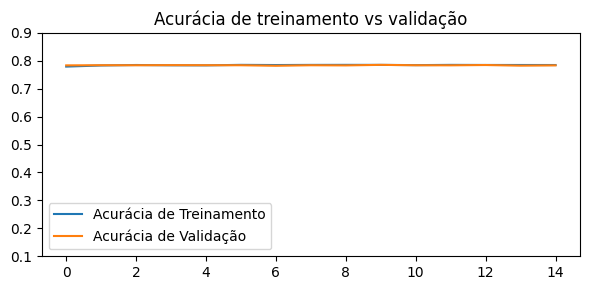

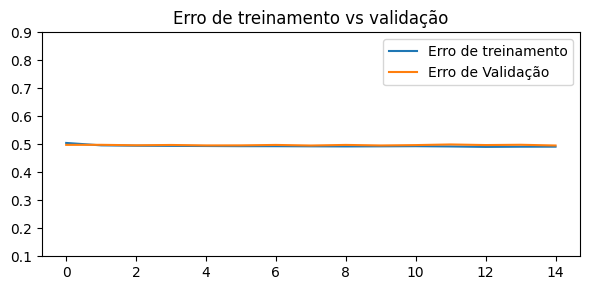

In [14]:
history = model.fit(X_train, y_train, epochs=15, batch_size=120, validation_split=0.2)

import matplotlib.pyplot as plt

# Plot 1 - Acurácia
plt.figure(figsize=(6, 3))
plt.ylim(0.1, 0.9)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia de treinamento vs validação')
plt.tight_layout()
plt.legend()
plt.show()

# Plot 2 - Erro
plt.figure(figsize=(6, 3))
plt.ylim(0.1, 0.9)
plt.plot(history.history['loss'], label='Erro de treinamento')
plt.plot(history.history['val_loss'], label='Erro de Validação')
plt.title('Erro de treinamento vs validação')
plt.tight_layout()
plt.legend()
plt.show()



# Função candidato
Essa etapa é responsável por ler os dados imputados de novos candidatos, e armazená-los na função para que possa ser testado se ele deve ser entrevistado ou não.

In [15]:
def prever_candidato(candidato_dict):
    """
    Recebe um dicionário com os dados do candidato e retorna se ele será aprovado ou não,
    com base no modelo treinado.
    """

    # Concatenar os campos de texto
    texto = " ".join([
        #candidato_dict.get("cv_pt", ""),
        candidato_dict.get("experiencias", ""),
        candidato_dict.get("endereco", ""),
        candidato_dict.get("certificacoes", ""),
        candidato_dict.get("cursos", "")
    ])

    if not texto.strip():
        texto = candidato_dict.get("cv_pt", "")

    # Tokenizar e vetorizar o texto usando o modelo FastText
    tokenized_texto = texto.split()
    texto_ft = document_vector(tokenized_texto).reshape(1, -1)

   # Valores informados
    nivel_academico = candidato_dict.get("nivel_academico", "")
    nivel_ingles = candidato_dict.get("nivel_ingles", "")
    nivel_espanhol = candidato_dict.get("nivel_espanhol", "")

    # Corrigir se estiver fora das classes treinadas
    if nivel_academico not in encoder_academico.classes_:
        nivel_academico = encoder_academico.classes_[0]  # ou exiba mensagem de aviso

    if nivel_ingles not in encoder_ingles.classes_:
        nivel_ingles = encoder_ingles.classes_[0]

    if nivel_espanhol not in encoder_espanhol.classes_:
        nivel_espanhol = encoder_espanhol.classes_[0]


    # Codificar atributos estruturados
    try:
        nivel_academico_val = candidato_dict.get("nivel_academico", "")
        nivel_ingles_val = candidato_dict.get("nivel_ingles", "")
        nivel_espanhol_val = candidato_dict.get("nivel_espanhol", "")
        nivel_academico = encoder_academico.transform([nivel_academico_val])[0]
        nivel_ingles = encoder_ingles.transform([nivel_ingles_val])[0]
        nivel_espanhol = encoder_espanhol.transform([nivel_espanhol_val])[0]

    except Exception as e:
        print(f"Erro ao codificar os níveis: {e}")
        return "Erro ao processar atributos estruturados"

    # Normalização dos atributos estruturados
    atributos_norm = scaler.transform([[nivel_academico, nivel_ingles, nivel_espanhol]])

    # Combinação do texto e atributos
    X_novo = np.hstack([texto_ft, atributos_norm])

    # Previsão se o candidato deverá ser chamado ou não
    prob = model.predict(X_novo)[0][0]
    print(f"Probabilidade de aprovação: {prob:.2%}")
    if prob < 0.15:
        return "❌ Reprovado — Candidato não possui aderência."
    elif 0.15 <= prob < 0.6:
        return "🟡 Chamar para entrevista — Candidato possui aderência mínima necessária e chances moderadas de contratação."
    else:
        return "✅ Chamar para entrevista — Candidato possui aderência necessária e altas chances de contratação."

# Teste

In [19]:
# Utilização de um candidato como exemplo
candidato_exemplo = {
    #"cv_pt": "\ncampinas/sp\n\nconsultant sap - abap/wf\n\n\...",
    "experiencias": "...",
    "endereco": "...",
    "certificacoes": "...",
    "cursos": "...",
    "nivel_academico": "Ensino Médio Incompleto",
    "nivel_ingles": "Básico",
    "nivel_espanhol": "Básico"
}

# Corração dos valores com base nos encoders treinados
valores_validos_academico = list(encoder_academico.classes_)
valores_validos_ingles = list(encoder_ingles.classes_)
valores_validos_espanhol = list(encoder_espanhol.classes_)


if candidato_exemplo["nivel_academico"] not in valores_validos_academico:
    print(f"Aviso: '{candidato_exemplo['nivel_academico']}' não reconhecido. Substituindo por '{valores_validos_academico[0]}'")
    candidato_exemplo["nivel_academico"] = valores_validos_academico[0]

if candidato_exemplo["nivel_ingles"] not in valores_validos_ingles:
    print(f"Aviso: '{candidato_exemplo['nivel_ingles']}' não reconhecido. Substituindo por '{valores_validos_ingles[0]}'")
    candidato_exemplo["nivel_ingles"] = valores_validos_ingles[0]

if candidato_exemplo["nivel_espanhol"] not in valores_validos_espanhol:
    print(f"Aviso: '{candidato_exemplo['nivel_espanhol']}' não reconhecido. Substituindo por '{valores_validos_espanhol[0]}'")
    candidato_exemplo["nivel_espanhol"] = valores_validos_espanhol[0]

# Execução do teste
resultado = prever_candidato(candidato_exemplo)
print("Resultado:", resultado)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Probabilidade de aprovação: 62.67%
Resultado: ✅ Chamar para entrevista — Candidato possui aderência necessária e altas chances de contratação.


In [17]:
import os
import joblib

# Criar a pasta 'modelo' se ainda não existir
os.makedirs("modelo", exist_ok=True)

from sklearn.neural_network import MLPClassifier
import joblib

# Após treinar o modelo
joblib.dump(model, "modelo/modelo_treinado.joblib")

['modelo/modelo_treinado.joblib']

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.40      0.45      0.42      1988
           1       0.84      0.81      0.82      7031

    accuracy                           0.73      9019
   macro avg       0.62      0.63      0.62      9019
weighted avg       0.74      0.73      0.73      9019

